Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

In [22]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value

################################
# load data, missing, outliers #
################################
combined_dataset_step1 <- 
    house_prices$helpers$load_data() %>%
    (house_prices$stage1_transformation)

################################
# transform numeric predictors #
################################
step2 <- house_prices$stage2_transformation(
    combined_dataset_step1,
    threshold = 20
)
trans_config <- step2$trans_config
combined_dataset_step2 <- step2$dataset
                
trans_config

house_prices$helpers$utils$frames_diff(
    combined_dataset_step1, 
    combined_dataset_step2
) %>% head

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 <- house_prices$stage3_transformation(combined_dataset_step2)

house_prices$helpers$utils$frames_diff(
    combined_dataset_step2, 
    combined_dataset_step3
) %>% head

var,tran_name,progress_score,tran_fn,r2_x,r2_tran
GrLivArea,log,91.15794,"function (x) , log(x + 1)",0.52593095,0.5438044
LotArea,inv4,78.86403,"function (x) , x^(1/4)",0.06788313,0.1591873
TotRmsAbvGrd,log,30.68502,"function (x) , log(x + 1)",0.28912299,0.2938676


GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2
1710,7.444833,8450,9.587694,8,2.197225
1262,7.141245,9600,9.898464,6,1.945910
1786,7.488294,11250,10.298836,6,1.945910
1717,7.448916,9550,9.885550,7,2.079442
2198,7.695758,14260,10.927728,9,2.302585
1362,7.217443,14115,10.899842,5,1.791759


Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,⋯,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,⋯,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


### Validation dataset 

Validation dataset is crucially different from training dataset. For model validation we must treat provided by Kaggle `train.csv` as combined data and split it into **training** and **validation** subsets. It is super important to make this split **BEFORE** transformation of categorical variables. For this transformation we must use information about sale price **ONLY** from **training** subset and pretend we do not know price in **validation** subset. Otherwise purity of validation process is violated as model is trained both on train and validation data.

In [3]:
##########################                
# dataset for validation #
##########################
validation_dataset <-
    # !!!before transformation of categ variables!!!
    combined_dataset_step2 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

validation_dataset %>% nrow %>% show_list

1458

In [4]:
# some shortcuts

iterate <- purrr::partial(house_prices$validate$iterate, 
                          target_var = price_log,
                          categ_transform = house_prices$trans$categ$rating_transform)

get_avg_report <- house_prices$validate$get_avg_report

### Model selection

In [6]:
house_prices <- source('main.R', local = TRUE)$value

formulas_for_validation <-
    house_prices$model_selection$lm$greedy_r2_gain_adj(
        data = combined_dataset_step3 %>% filter(dataSource == 'train') %>% select(-dataSource), 
        target_var = price_log, 
        r2_gain_discard_level = 0.1,
        r2_discard_level = 0.01, 
        a_max = 0, a_avg = 1
    ) %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

formulas_for_validation

step,formula
1,price_log ~ OverallQual
2,price_log ~ OverallQual + LotArea
3,price_log ~ OverallQual + LotArea + GrLivArea
4,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt
5,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1
6,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd
7,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition
8,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir
9,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood
10,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF


In [7]:
set.seed(8)

valid_report <- suppressWarnings(
    caret::createDataPartition(
        y = validation_dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation, sample_index, validation_dataset) })
) %>% 
bind_rows(.id='sample')

valid_report %>% group_by(sample) %>% filter(row_number() %in% c(1, 2, max(step)))

sample,step,formula,r2,L2_train,L2_valid
Resample01,1,price_log ~ OverallQual,0.6790126,0.05179864,0.05219710
Resample01,2,price_log ~ OverallQual + LotArea,0.7467464,0.04086824,0.04039229
Resample01,16,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF + GarageCars + Condition1 + KitchenQual + ScreenPorch + MSZoning + Fireplaces,0.9064293,0.01509977,0.01585380
Resample02,1,price_log ~ OverallQual,0.6815423,0.04753301,0.05637917
Resample02,2,price_log ~ OverallQual + LotArea,0.7464122,0.03785053,0.04332776
Resample02,16,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF + GarageCars + Condition1 + KitchenQual + ScreenPorch + MSZoning + Fireplaces,0.8998893,0.01494253,0.01665944
Resample03,1,price_log ~ OverallQual,0.6413272,0.05558129,0.04828376
Resample03,2,price_log ~ OverallQual + LotArea,0.7210459,0.04322778,0.03781819
Resample03,16,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF + GarageCars + Condition1 + KitchenQual + ScreenPorch + MSZoning + Fireplaces,0.8915695,0.01680279,0.01398945
Resample04,1,price_log ~ OverallQual,0.6632645,0.05362075,0.05051280


### Averaging vaidation report across samples

In [8]:
avg_report <- valid_report %>% get_avg_report
avg_report

formula,r2,L2_train,L2_valid,step,L2_valid_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + LotArea,0.7425354,0.04048551,0.04067756,2,0.0118252136
price_log ~ OverallQual + LotArea + GrLivArea,0.7924489,0.03263215,0.03304361,3,0.0076339501
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt,0.8343216,0.02604849,0.02613031,4,0.0069132999
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1,0.8568478,0.02250598,0.02208950,5,0.0040408068
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd,0.8659281,0.02107985,0.02071659,6,0.0013729125
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition,0.8728139,0.01999517,0.01992818,7,0.0007884139
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir,0.8774142,0.01926655,0.01914890,8,0.0007792735
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood,0.8842388,0.01819172,0.01820365,9,0.0009452507
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8890352,0.01743614,0.01727302,10,0.0009306299


### Plotting training and validation errors

Left - on average across samples, right - for every sample.

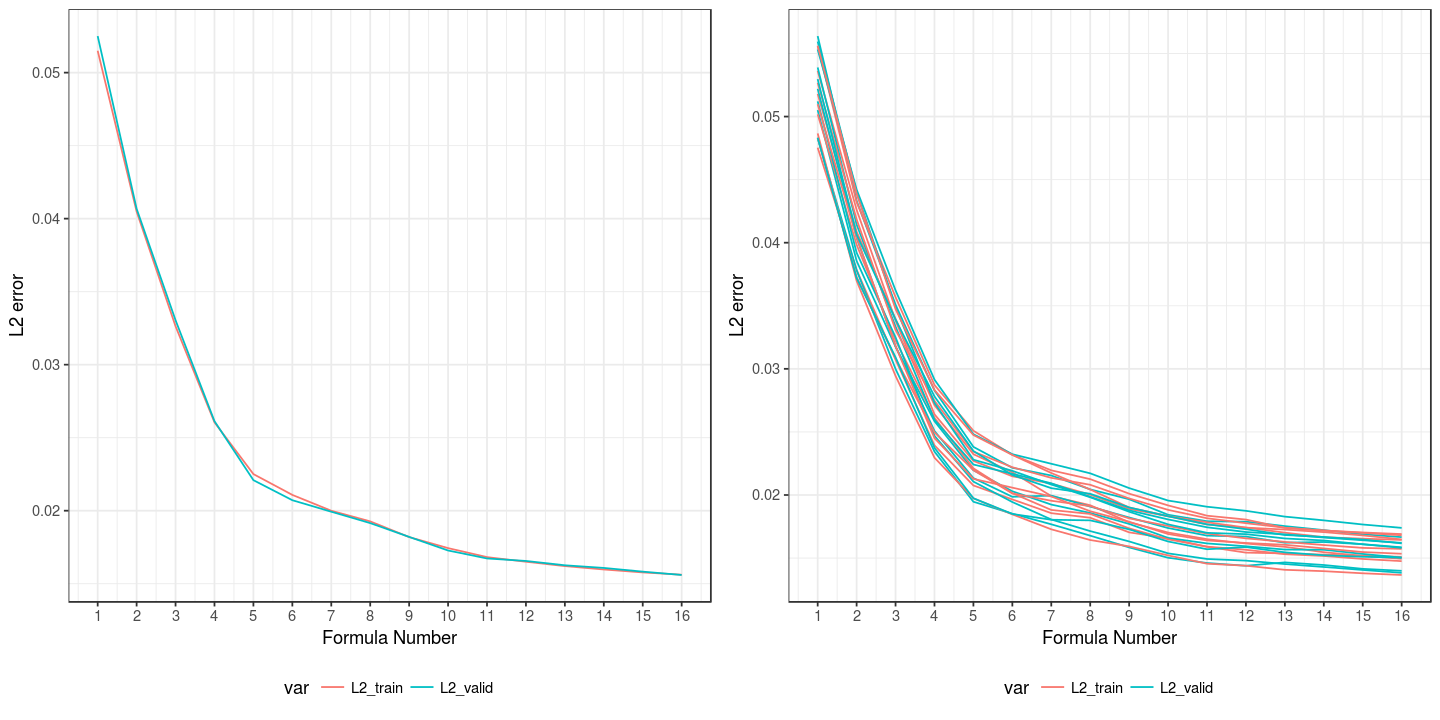

In [9]:
options(repr.plot.width = 12, repr.plot.height = 6)
house_prices$validate$plot_report(valid_report)

### Let's try another model

In [11]:
formulas_for_validation2 <-
    house_prices$model_selection$lm$greedy_r2_gain_adj(
        data = combined_dataset_step3 %>% filter(dataSource == 'train') %>% select(-dataSource), 
        target_var = price_log, 
        r2_gain_discard_level = 0.1,
        r2_discard_level = 0.01, 
        a_max = 0, a_avg = 0
    ) %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

set.seed(8)

valid_report2 <- suppressWarnings(
    caret::createDataPartition(
        y = validation_dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation2, sample_index, validation_dataset) })
) %>% 
bind_rows(.id='sample')

avg_report2 <- valid_report2 %>% get_avg_report
avg_report2

formula,r2,L2_train,L2_valid,step,L2_valid_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + GrLivArea,0.7621208,0.03739894,0.03804852,2,0.0144542507
price_log ~ OverallQual + GrLivArea + Neighborhood,0.8111162,0.02969291,0.03054179,3,0.0075067307
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1,0.8456728,0.02425718,0.02433128,4,0.0062105091
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea,0.8579926,0.02232132,0.02243408,5,0.0018972051
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir,0.8662802,0.02101241,0.02091718,6,0.0015168967
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea,0.8735544,0.01986861,0.01959460,7,0.0013225840
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd,0.8823531,0.01849098,0.01829155,8,0.0013030415
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF,0.8874584,0.01768611,0.01734196,9,0.0009495906
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF + SaleCondition,0.8924121,0.01690669,0.01681691,10,0.0005250552


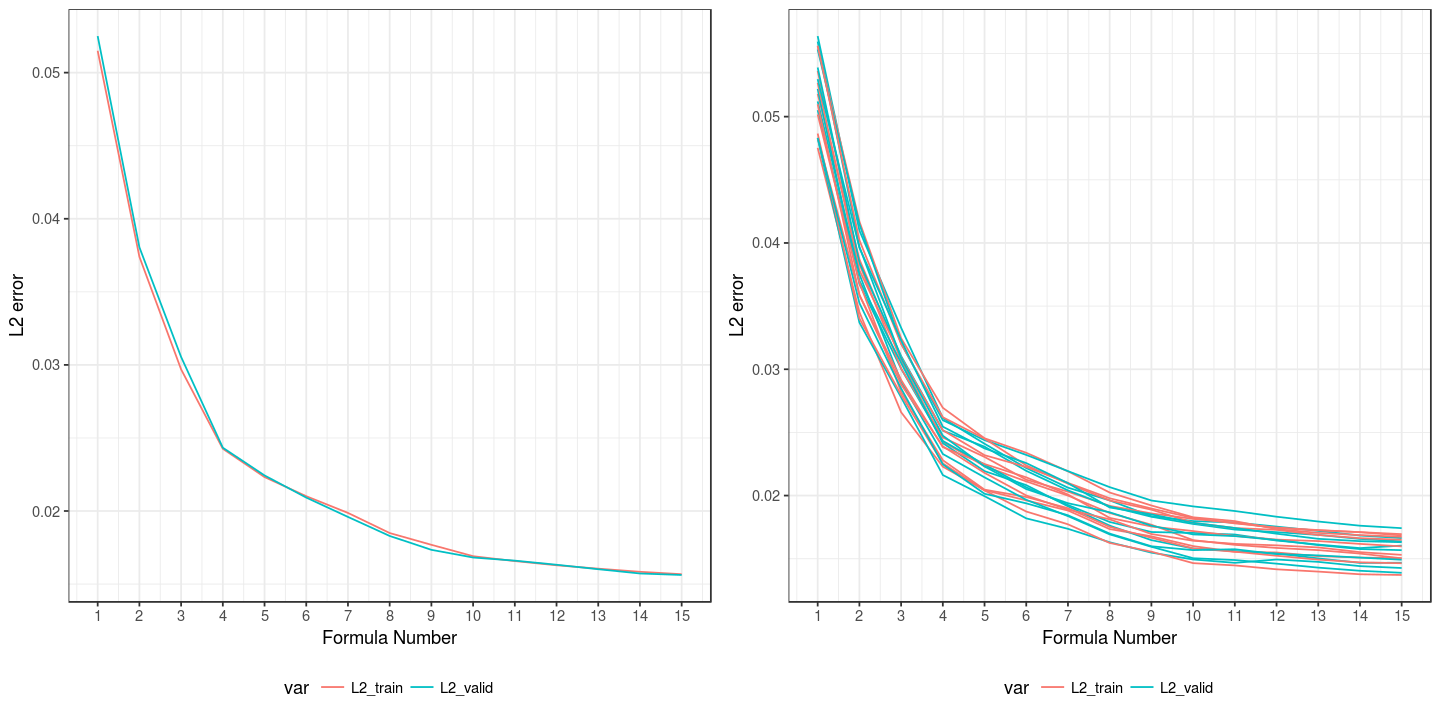

In [12]:
options(repr.plot.width = 12, repr.plot.height = 6)
house_prices$validate$plot_report(valid_report2)

### Compare two models

Black - first model, blue - second.

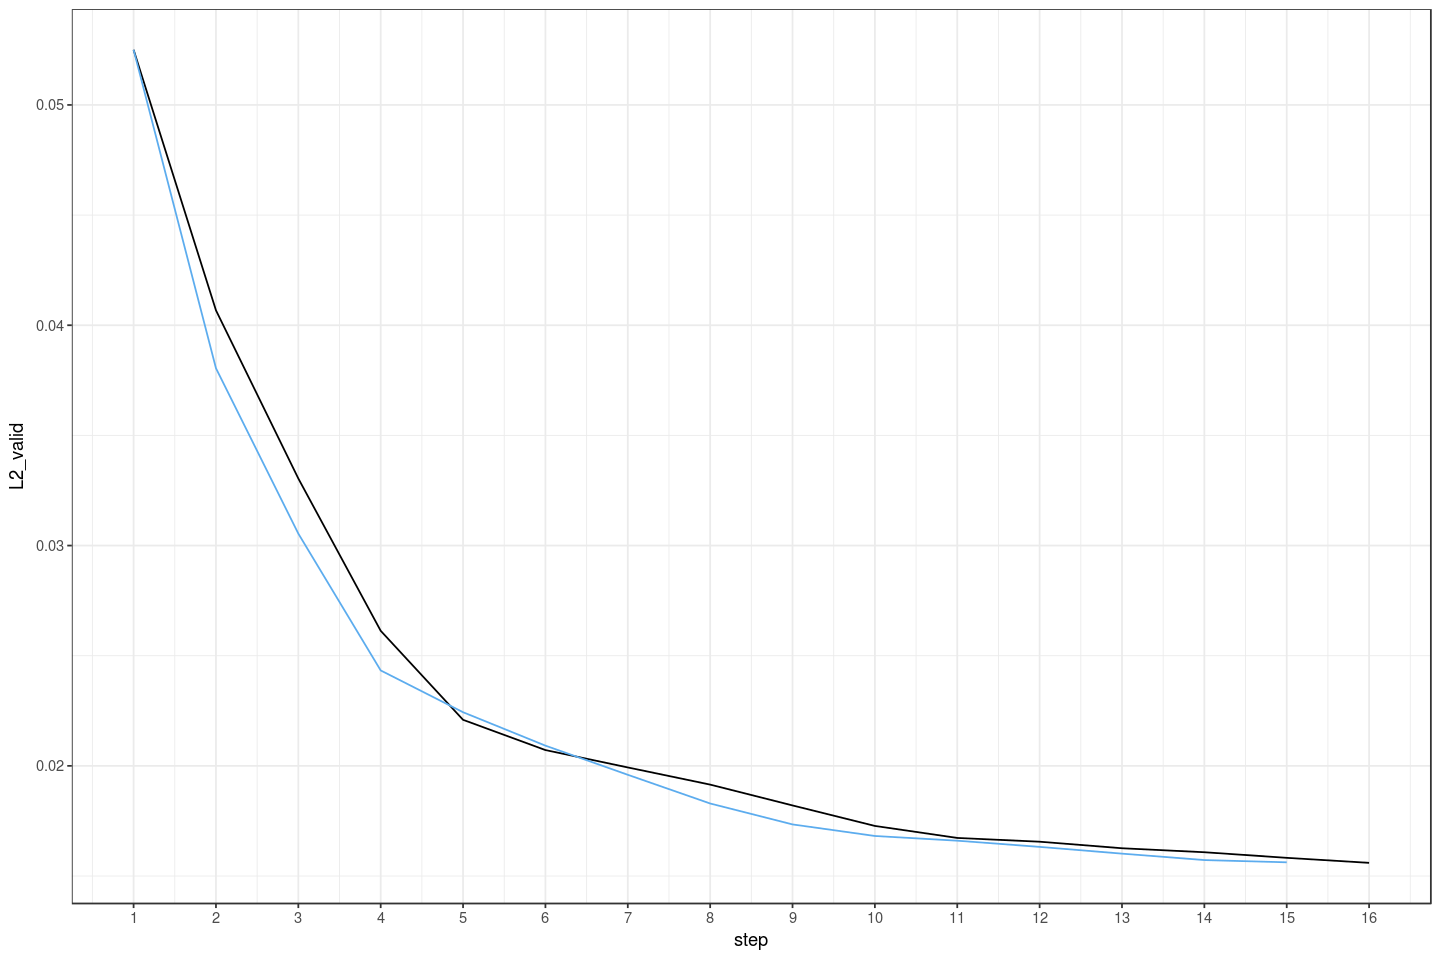

In [15]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot() +
geom_line(aes(x=step, y=L2_valid, group=1), data=avg_report) +
geom_line(aes(x=step, y=L2_valid, group=1), color='steelblue2', data=avg_report2) +
scale_x_continuous(breaks=c(1:max(avg_report$step))) +
theme_bw()

First model is doing slightly better so it is choosen for submission.

Final regression formula price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF + GarageCars + Condition1 + KitchenQual + ScreenPorch + MSZoning + Fireplaces

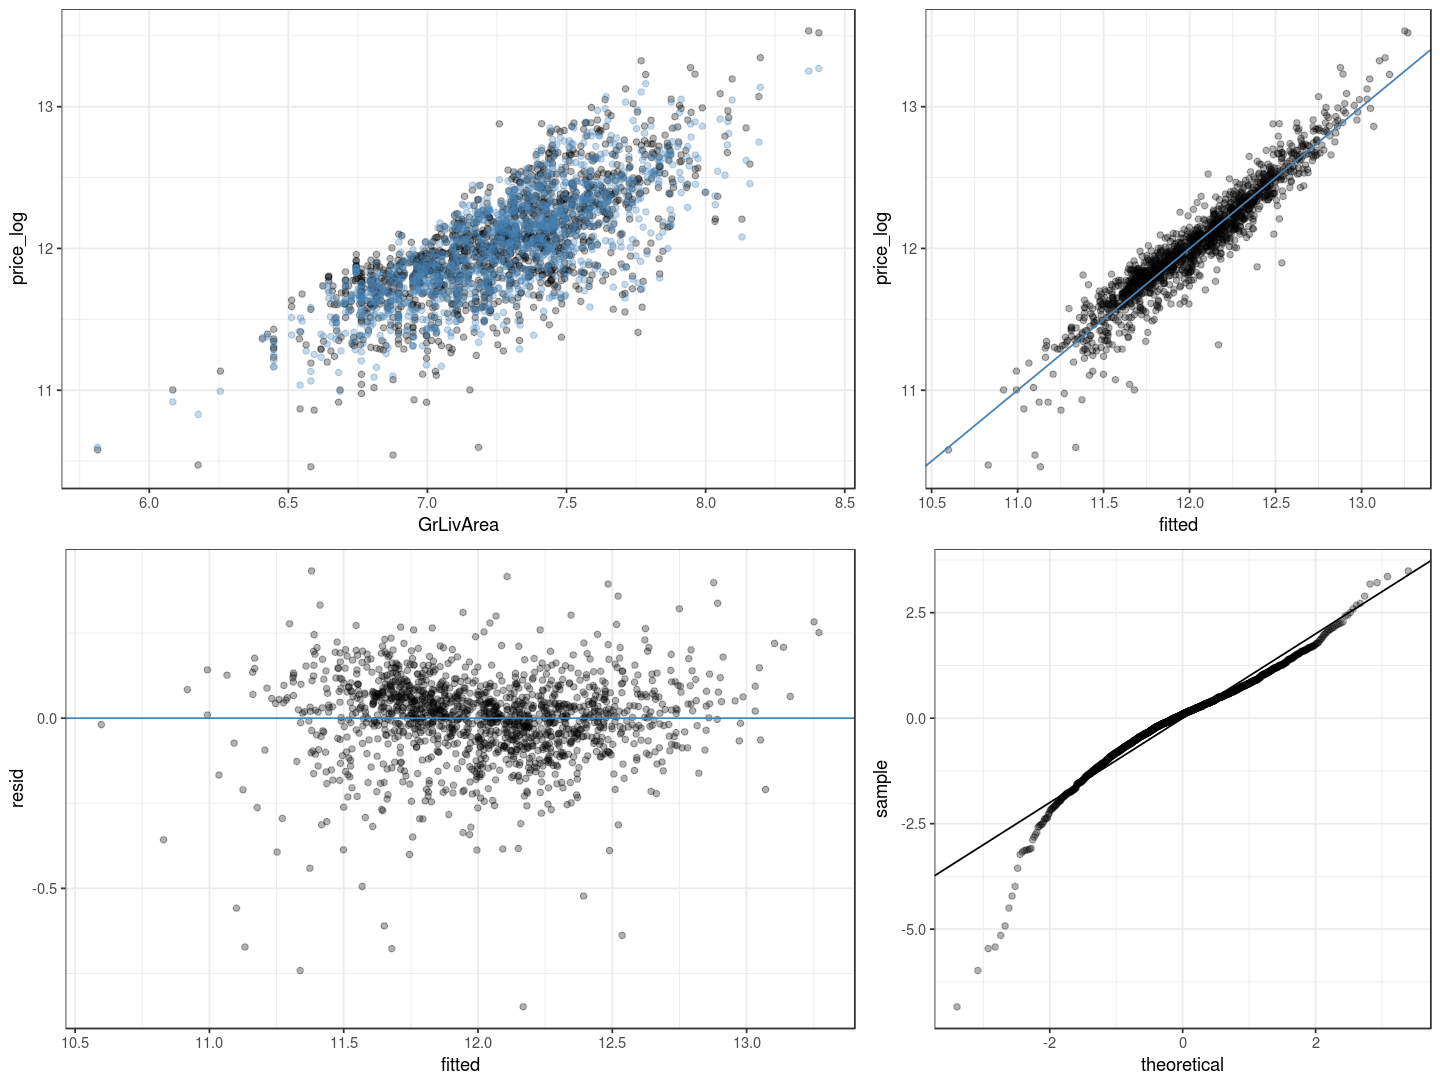

In [23]:
f <- avg_report[["formula"]] %>% tail(1)

f %>% show_list("Final regression formula")

training_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

testing_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'test') %>% 
    select(-dataSource)

model <- lm(as.formula(f), data=training_dataset %>% select(-Id))

options(repr.plot.width = 12, repr.plot.height = 9)
house_prices$plot$lm_fit_diagnostic(model, "GrLivArea", "price_log")

### Submission

In [17]:
submit <- 
    testing_dataset %>%
    mutate(
        predicted = predict(model, testing_dataset)
    ) %>%
    select(Id, predicted) %>%
    mutate(
        SalePrice = exp(predicted)
    ) %>%
    select(Id, SalePrice)

write.csv(submit, "/tmp/submission.csv", row.names = FALSE)